In [1]:
# use full window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import numpy as np
os.chdir('..')
import virl
from matplotlib import pyplot as plt

In [2]:
env = virl.Epidemic(stochastic=False, noisy=False)
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])




In [3]:
# Let's import basic tools for defining the function and doing the gradient-based learning
import sklearn.pipeline
import sklearn.preprocessing
#from sklearn.preprocessing import PolynomialFeatures # you can try with polynomial basis if you want (It is difficult!)
from sklearn.linear_model import SGDRegressor # this defines the SGD function
from sklearn.kernel_approximation import RBFSampler # this is the RBF function transformation method
import pandas as pd
#import display, HTML
from IPython import display


def smooth_plot(all_rewards, smoothed_rewards,title): 
    plt.figure(2, figsize=(12, 6))
    plt.clf()
    plt.title(title)
    plt.xlabel("Epsiode") 
    plt.ylabel("Total Reward")
    plt.plot(all_rewards, '--', alpha=0.5) 
    plt.plot(smoothed_rewards) 
    plt.legend(["Rewards", "Rewards (Smoothed)"]) 
    plt.pause(0.0001)
   # display.clear_output(wait=True)

In [4]:

class LinearAprxAgent:
    def create_policy(self,func_approximator, epsilon):
        # from lab 8
        def policy_fn(state):
            """
            
            Input:
                state: a 2D array with the position and velocity
            Output:
                A,q_values: 
            """
            action_index = np.ones(self.num_of_actions, dtype=float) * epsilon / self.num_of_actions
            
            #transform to the same shape as the model was trained on
            state_transformed = self.feature_transformer.transform([state])
            q_values = self.func_approximator.predict(state_transformed)
           
            best_action = np.argmax(q_values)
            action_index[best_action] += (1.0 - epsilon)
            
            
            return action_index,q_values  # return the potentially stochastic policy (which is due to the exploration)

        return policy_fn # return a handle to the function so we can call it in the future
        
    def __init__(self,env):
        
        #RBF Hyper parameters
        SGD_learning_rate = "optimal" #‘constant’, ‘optimal’, ‘invscaling’, ‘adaptive’
        tol = 1e-5 #The stopping criterion
        SGD_max_iter = 1e4
        
        
        self.func_approximator =  SGDRegressor(learning_rate=SGD_learning_rate, tol=tol, max_iter=SGD_max_iter, loss='huber')
        self.feature_transformer =  sklearn.pipeline.FeatureUnion([
                ("rbf1", RBFSampler(gamma=12.8, n_components=50)),
                ("rbf2", RBFSampler(gamma=6.4, n_components=50)),
                ("rbf3", RBFSampler(gamma=3.2, n_components=50)),
                ("rbf4", RBFSampler(gamma=1.6, n_components=50)),
                ("rbf5", RBFSampler(gamma=0.8, n_components=50)),
                ("rbf6", RBFSampler(gamma=0.4, n_components=50)),
                ("rbf7", RBFSampler(gamma=0.2, n_components=50)),
                ("rbf8", RBFSampler(gamma=0.1, n_components=50))
                ])
        
        
        self.num_of_actions = env.action_space.n
        self.env = env
        #function which is the learned function
        self.policy = self.create_policy(self.func_approximator,1)
        
        self.episodes = 500
        self.print_out_every_x_episodes = int(self.episodes/50)
        self.times_exploited = 0
        
        # hyper parameters for epsilon explore
        self.initial_epsilon = 1 # initial
        self.decrease_factor = (1/self.episodes)/1.25 # epsilon
        print("Decrease Factor: " + str(self.decrease_factor))
        
    def train(self):
        states,all_rewards, all_total_rewards = self.run_all_episodes("Training")
        return states,all_rewards, all_total_rewards

    def evaluate(self,episodes=100):
        self.episodes = episodes
        self.epsilon = -1000
        states,all_rewards, all_total_rewards = self.run_all_episodes("Evaluation")
        return states,all_rewards, all_total_rewards
        
    
    def run_all_episodes(self,title):
        all_total_rewards = []
        all_rewards = []
        epsilon = self.initial_epsilon # at the start only explore
        
        
        power = 1
        for episode in range(1, self.episodes + 1):
            states,rewards = self.run_episode(epsilon)
            total_reward = np.sum(rewards)
            
            
#             if episode % self.print_out_every_x_episodes == 0:
#                 print("Episode number: " + str(episode) + ". Total reward in episode: " + str(total_reward) + ". Episode executed with epsilon = " + str(epsilon))
#                 print("Average total reward in last " + str(self.print_out_every_x_episodes) + " episodes: " + str(np.mean(all_rewards[-self.print_out_every_x_episodes:])))
#                 print("Times exploited the last episode " + str(self.times_exploited))
#                 print("-----")
            self.times_exploited = 0
            all_rewards.append(rewards)
            all_total_rewards.append(total_reward)
            epsilon = self.decrease_epsilon(epsilon, power)
            power += 0.10
        
        #graph with orange smoothed reward
        window_size = int(self.episodes/10)
        smoothed_rewards = pd.Series(all_total_rewards).rolling(window_size, min_periods=window_size).mean() 
        this_smoothed_reward = smoothed_rewards.values[-1]
        smooth_plot(all_total_rewards, smoothed_rewards,title)
        return states,all_rewards, all_total_rewards
    
    
    #exponential decrease in epsilon
    def decrease_epsilon(self, epsilon, power):
        decrease = 0.005
        return epsilon * ((1 - decrease) ** power)
    
    def run_episode(self,epsilon):
        rewards = []
        states = []
        actions = []
        done = False
        
        state = self.env.reset()
        states.append(state)
        
      
        
        while not done:
            random_number = np.random.random()
            if random_number < epsilon:
                #explore
                action = np.random.choice(self.num_of_actions)
                
            else:
                #exploit
                action = self.get_action(state)
                self.times_exploited += 1
              
            
            new_state, reward, done, i = self.env.step(action=action)
            
            states.append(new_state)
            actions.append(action)    
            rewards.append(reward)
            
            if epsilon != -1000:
                #update policy function
                self.update(states[1:],rewards, epsilon)
        
            
            state = new_state
      
        return states,rewards
        
    def update(self,states,rewards, epsilon):
        
        #update the linear function
        self.feature_transformer.fit(states)
        states_transformed = self.feature_transformer.transform(states)
        
        
        self.func_approximator.fit(states_transformed,rewards)
        self.policy = self.create_policy(self.func_approximator,epsilon)
                                                       
        
    def get_action(self,state):
        #linear function to get best action
        actions,q_values = self.policy(state)
        return np.argmax(actions)
    
    def get_action_text(self):
        return action_text
    
    def get_env(self):
        return env
    
    def get_chart_title(self):
        return "Action = " + action_text

### Training

In [ ]:
def plot(state,agent, total_rewards, rewards,title):
    fig, axes = plt.subplots(1, 4, figsize=(40, 16))
    labels = ['s[0]: susceptibles', 's[1]: infectious', 's[2]: quarantined', 's[3]: recovereds']
    states = np.array(state)
    for i in range(4):
        axes[0].plot(states[:,i], label=labels[i]);
        
    axes[0].set_xlabel(title + 'weeks since start of epidemic')
    axes[0].set_ylabel('State s(t)')
    axes[0].legend()
    axes[0].title.set_text('Final state')
    
   
    axes[1].plot(total_rewards);
    axes[1].set_xlabel('episode number')
    axes[1].set_ylabel('total reward r(t)')
    axes[1].title.set_text('Total reward per episode')


    axes[2].plot(rewards[0]);
    axes[2].set_xlabel('episode number')
    axes[2].set_ylabel('total reward r(t)')
    axes[2].title.set_text('First Episode reward')
    
   
    axes[3].plot(rewards[-1]);
    axes[3].set_xlabel('episode number')
    axes[3].set_ylabel('total reward r(t)')
    axes[3].title.set_text('Final Episode reward')

Problem id: 0

Decrease Factor: 0.0016


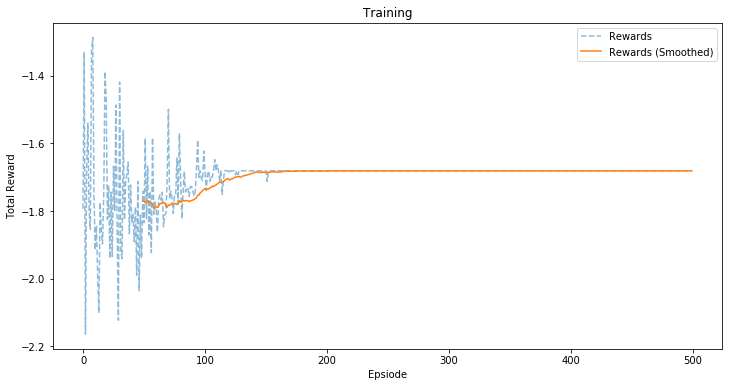

Train
Evaluate


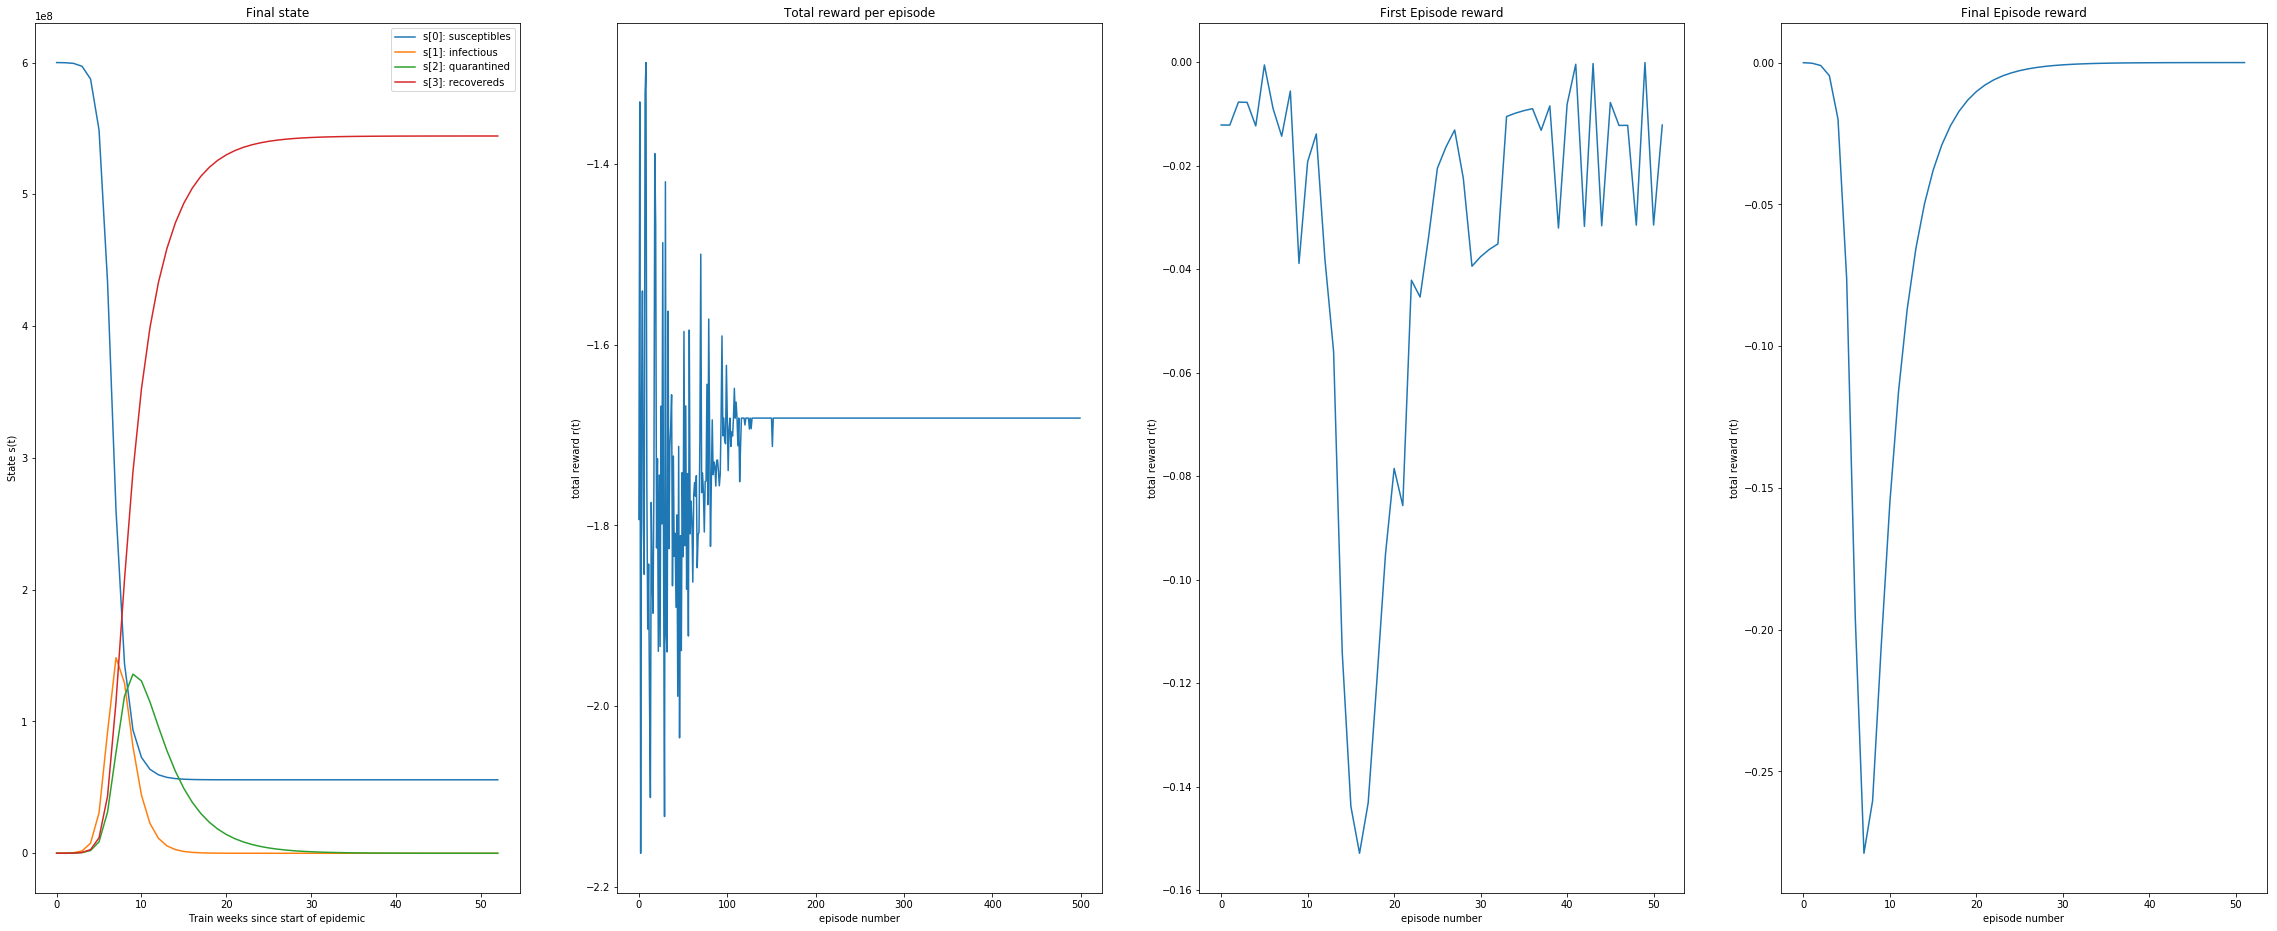

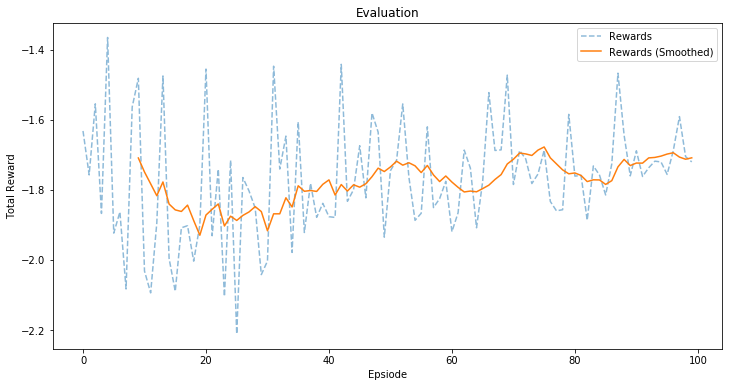

Problem id: 1

Decrease Factor: 0.0016


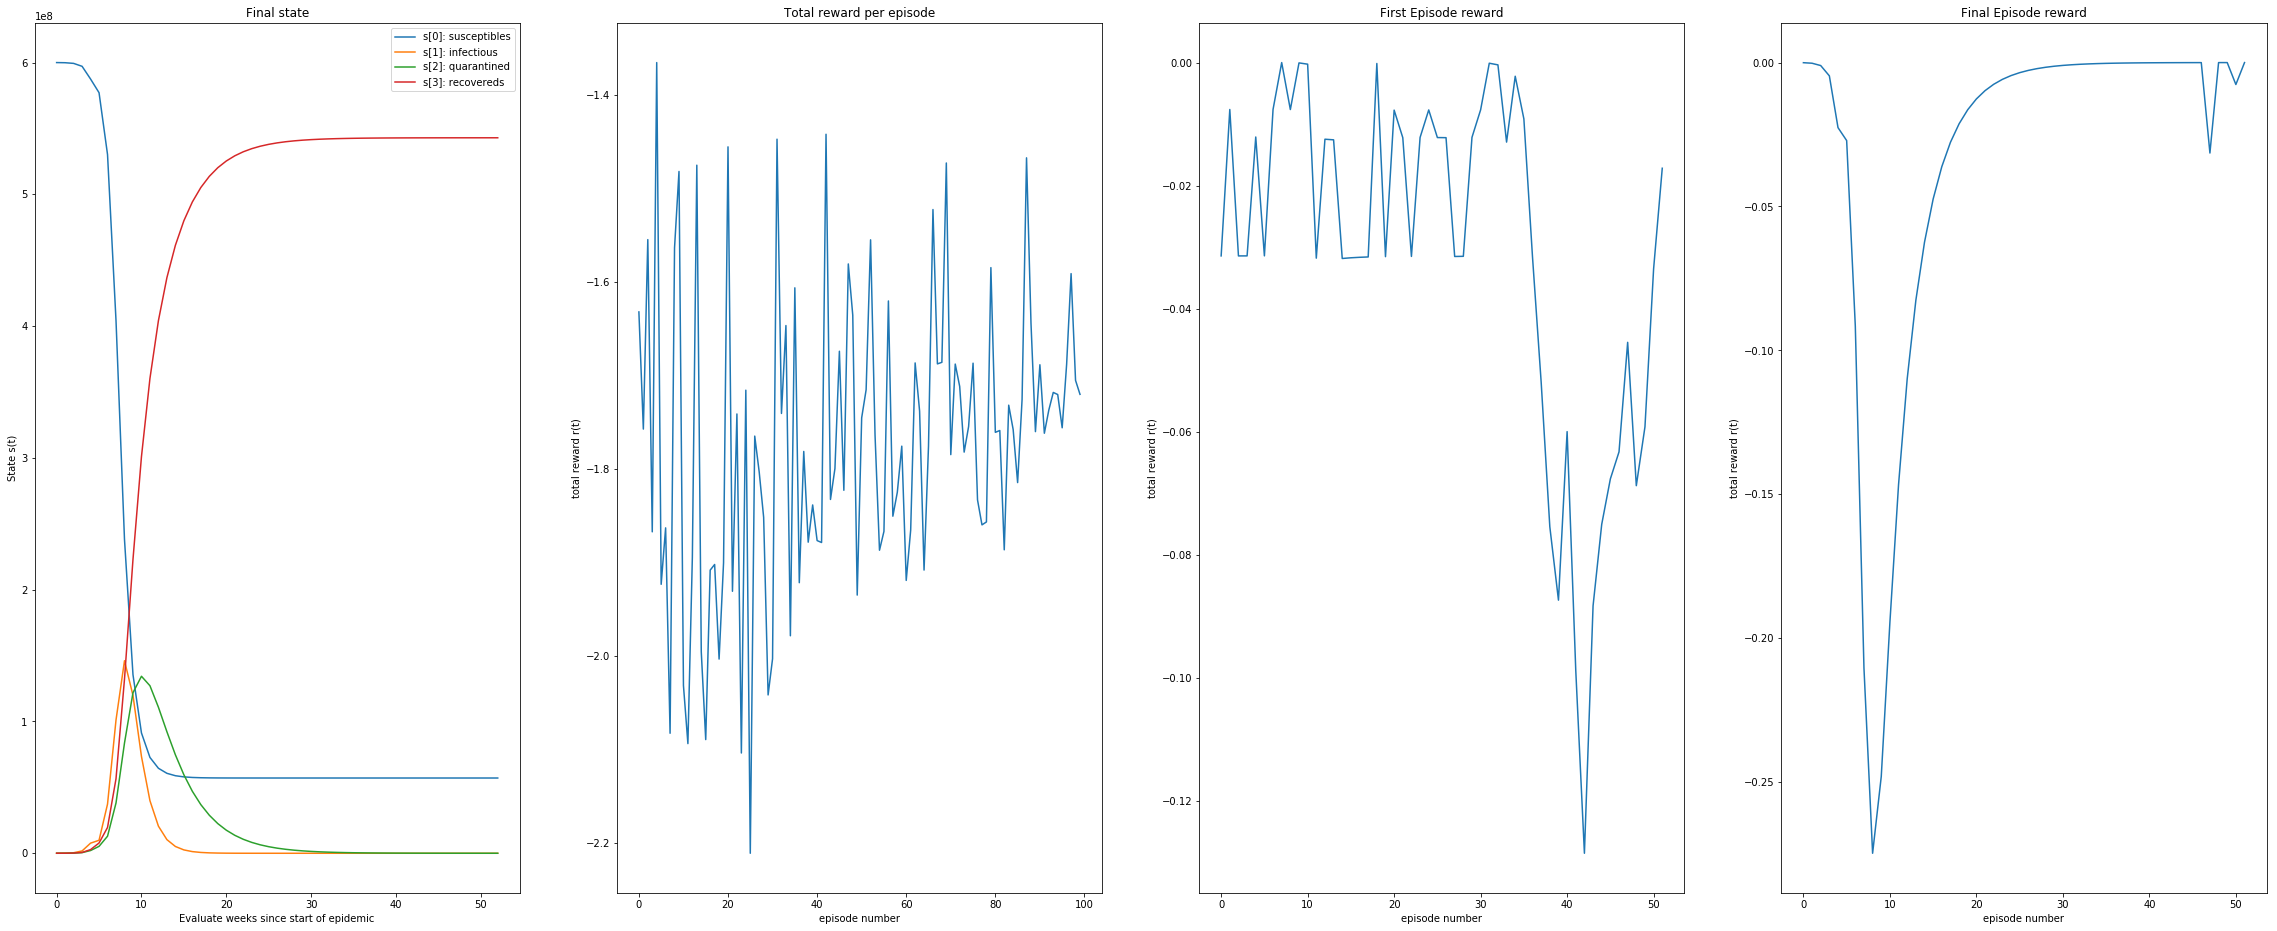

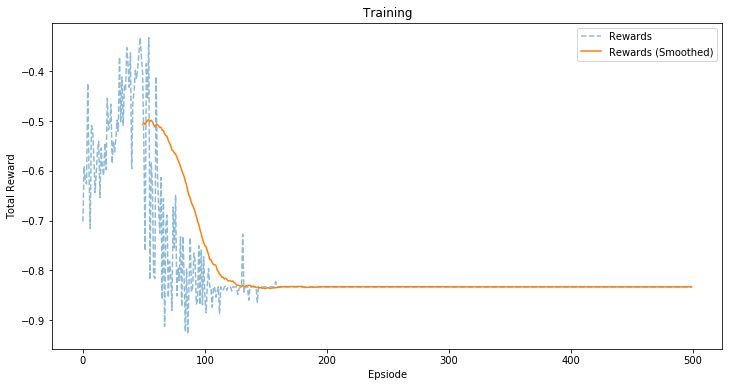

Train
Evaluate


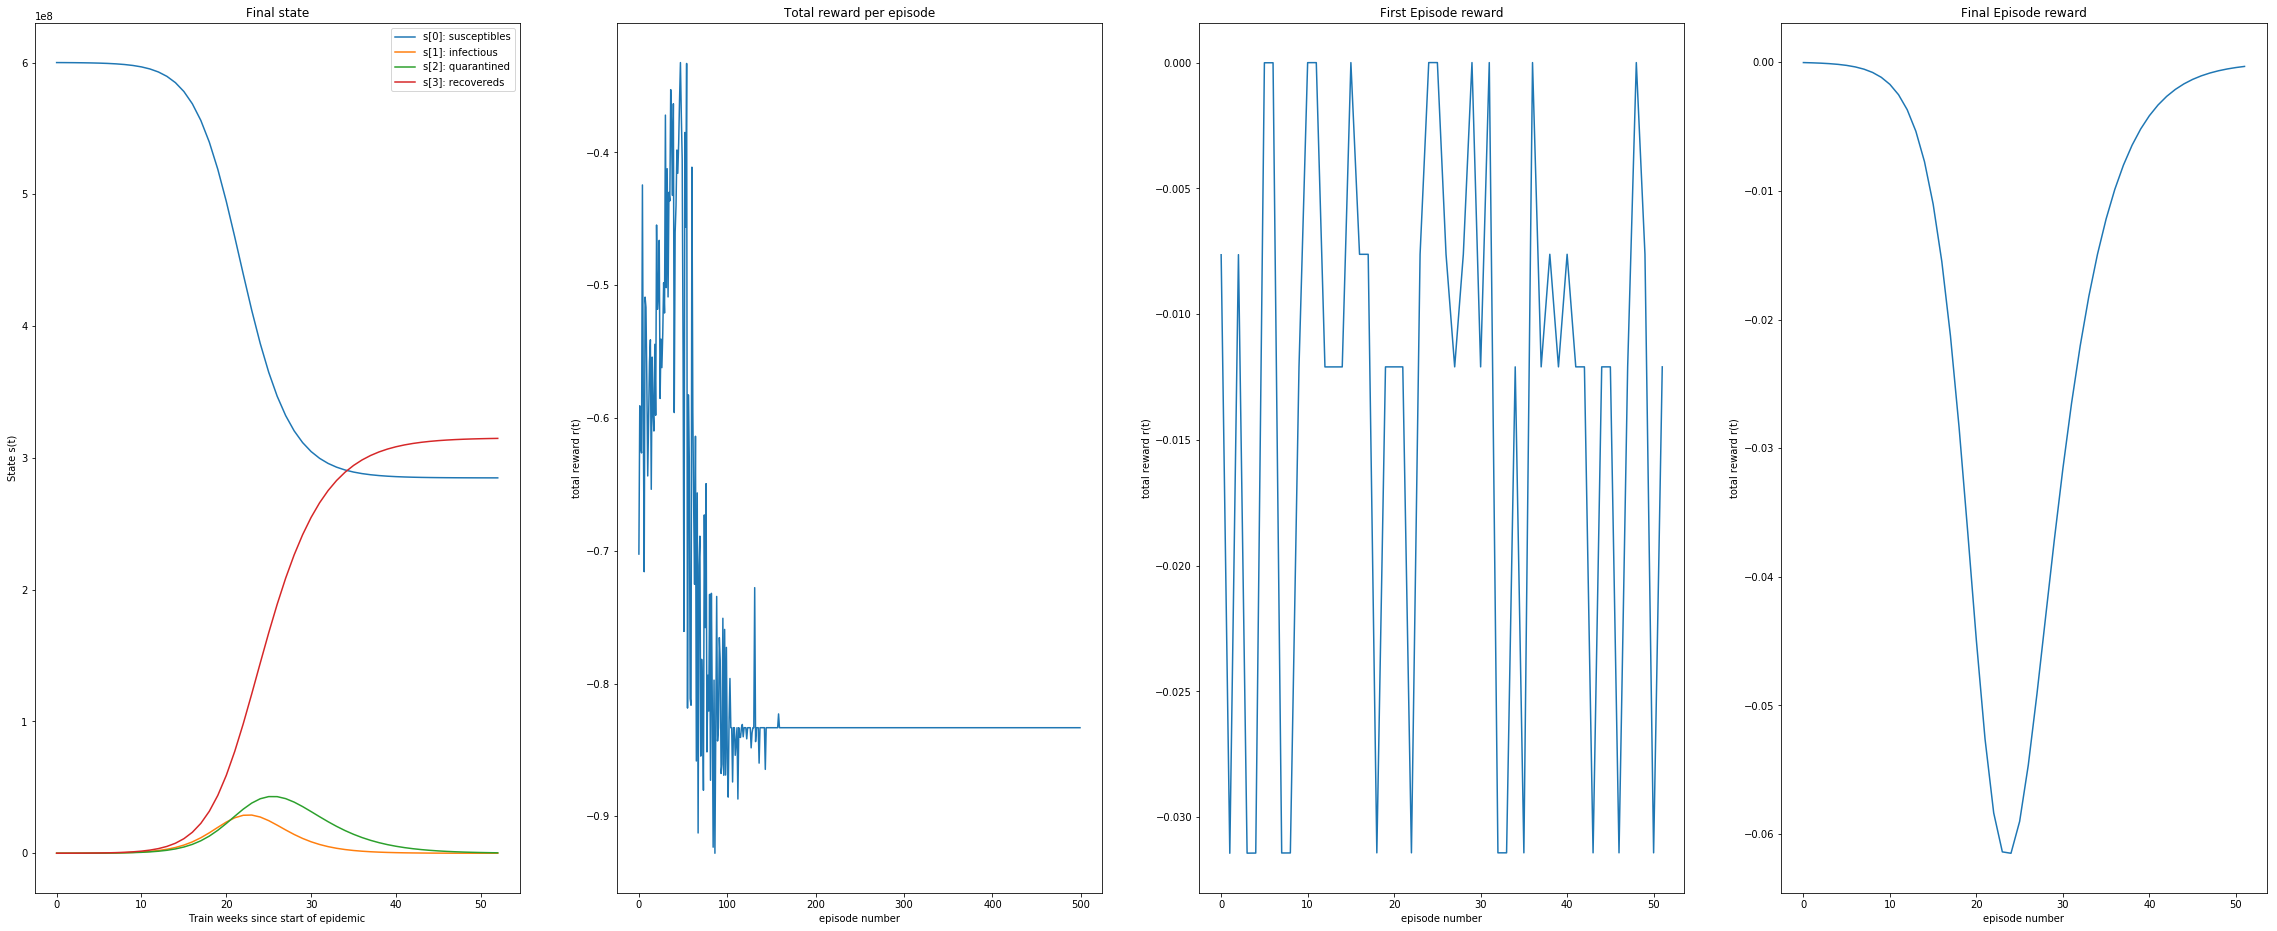

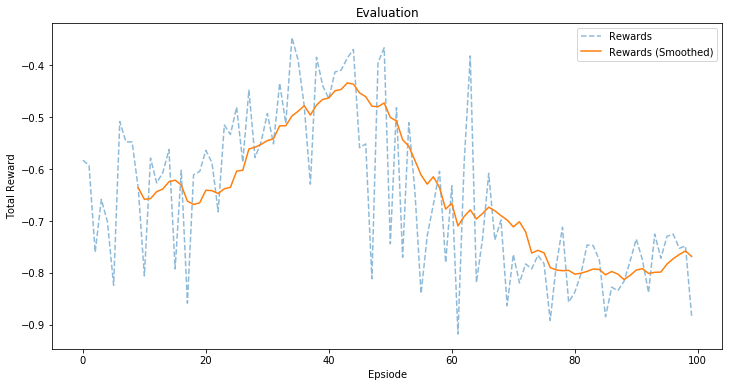

Problem id: 2

Decrease Factor: 0.0016


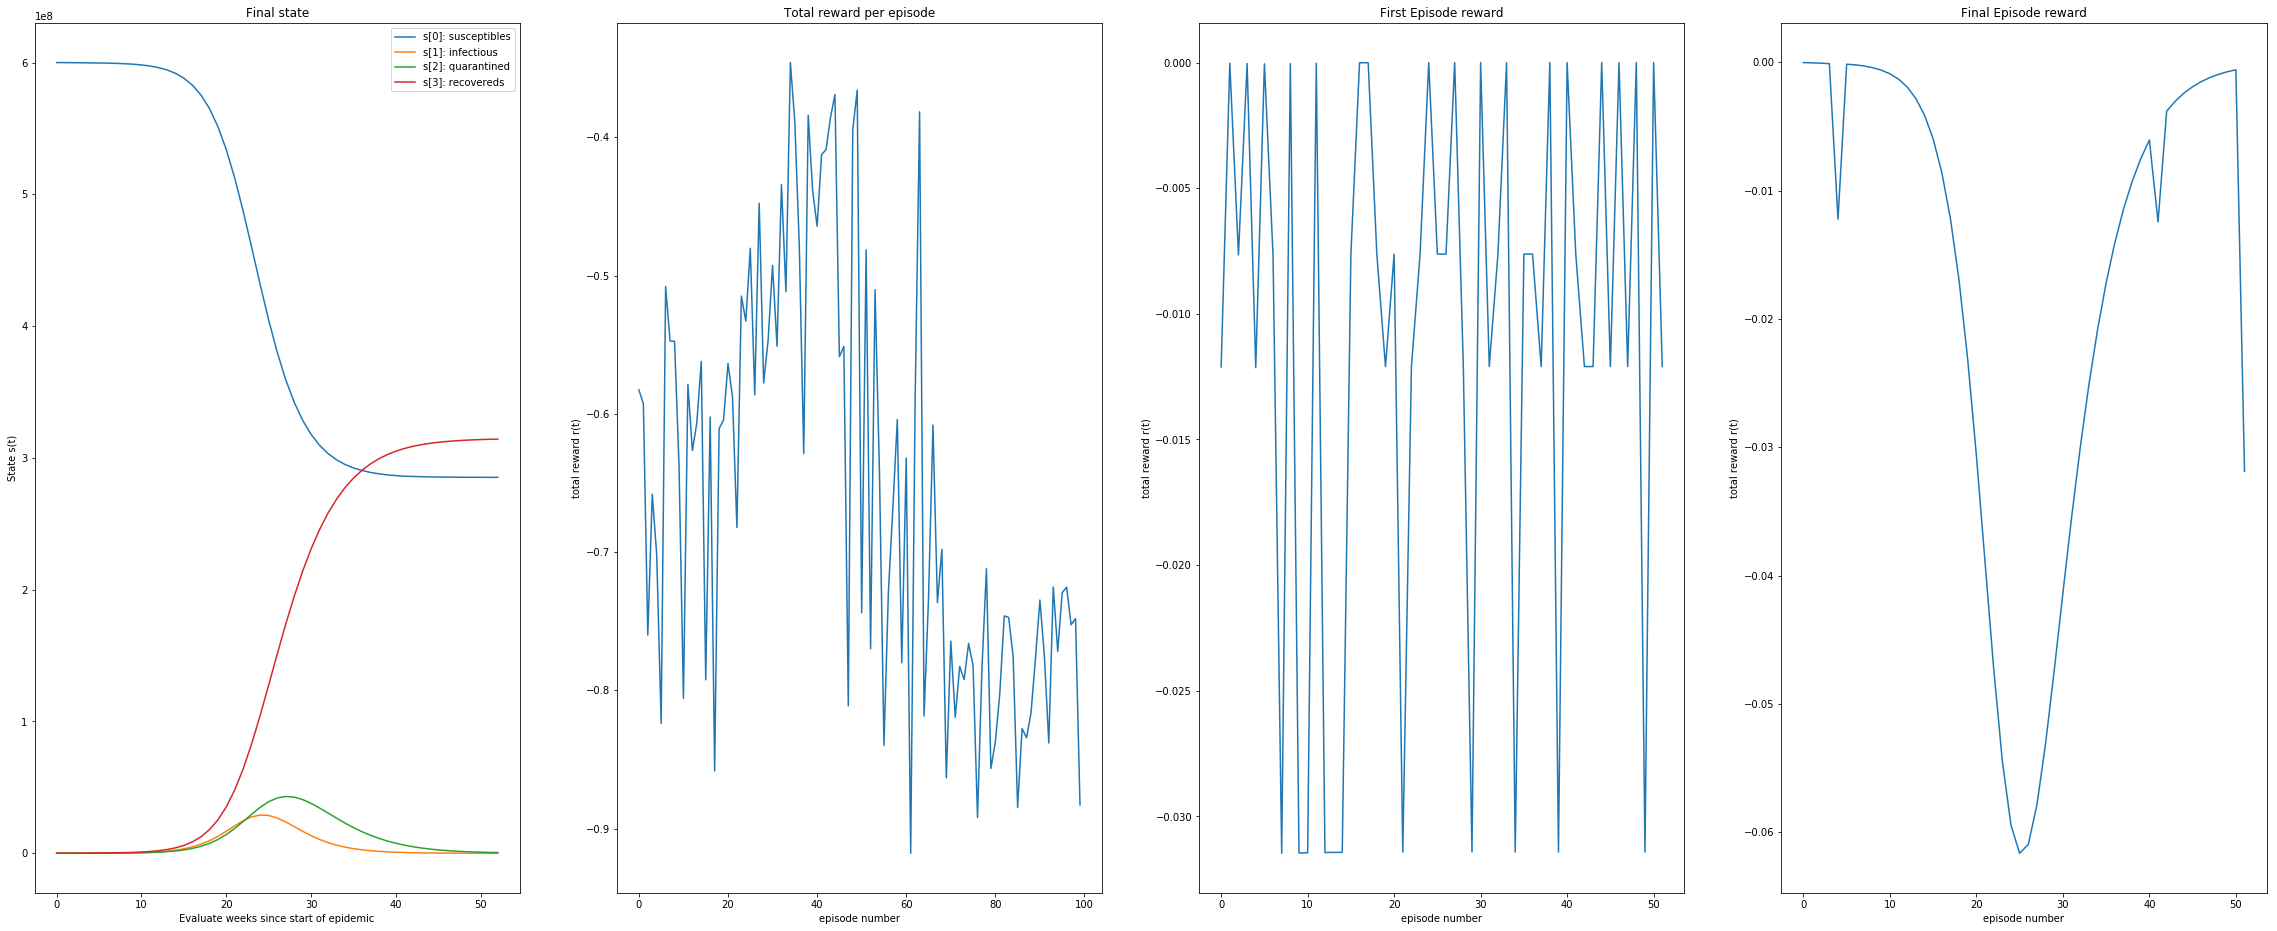

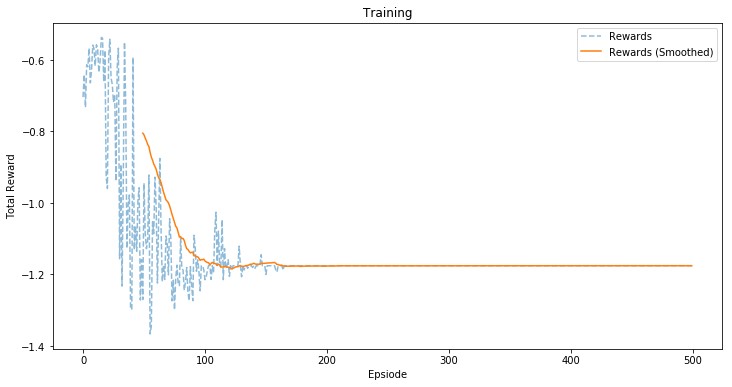

Train
Evaluate


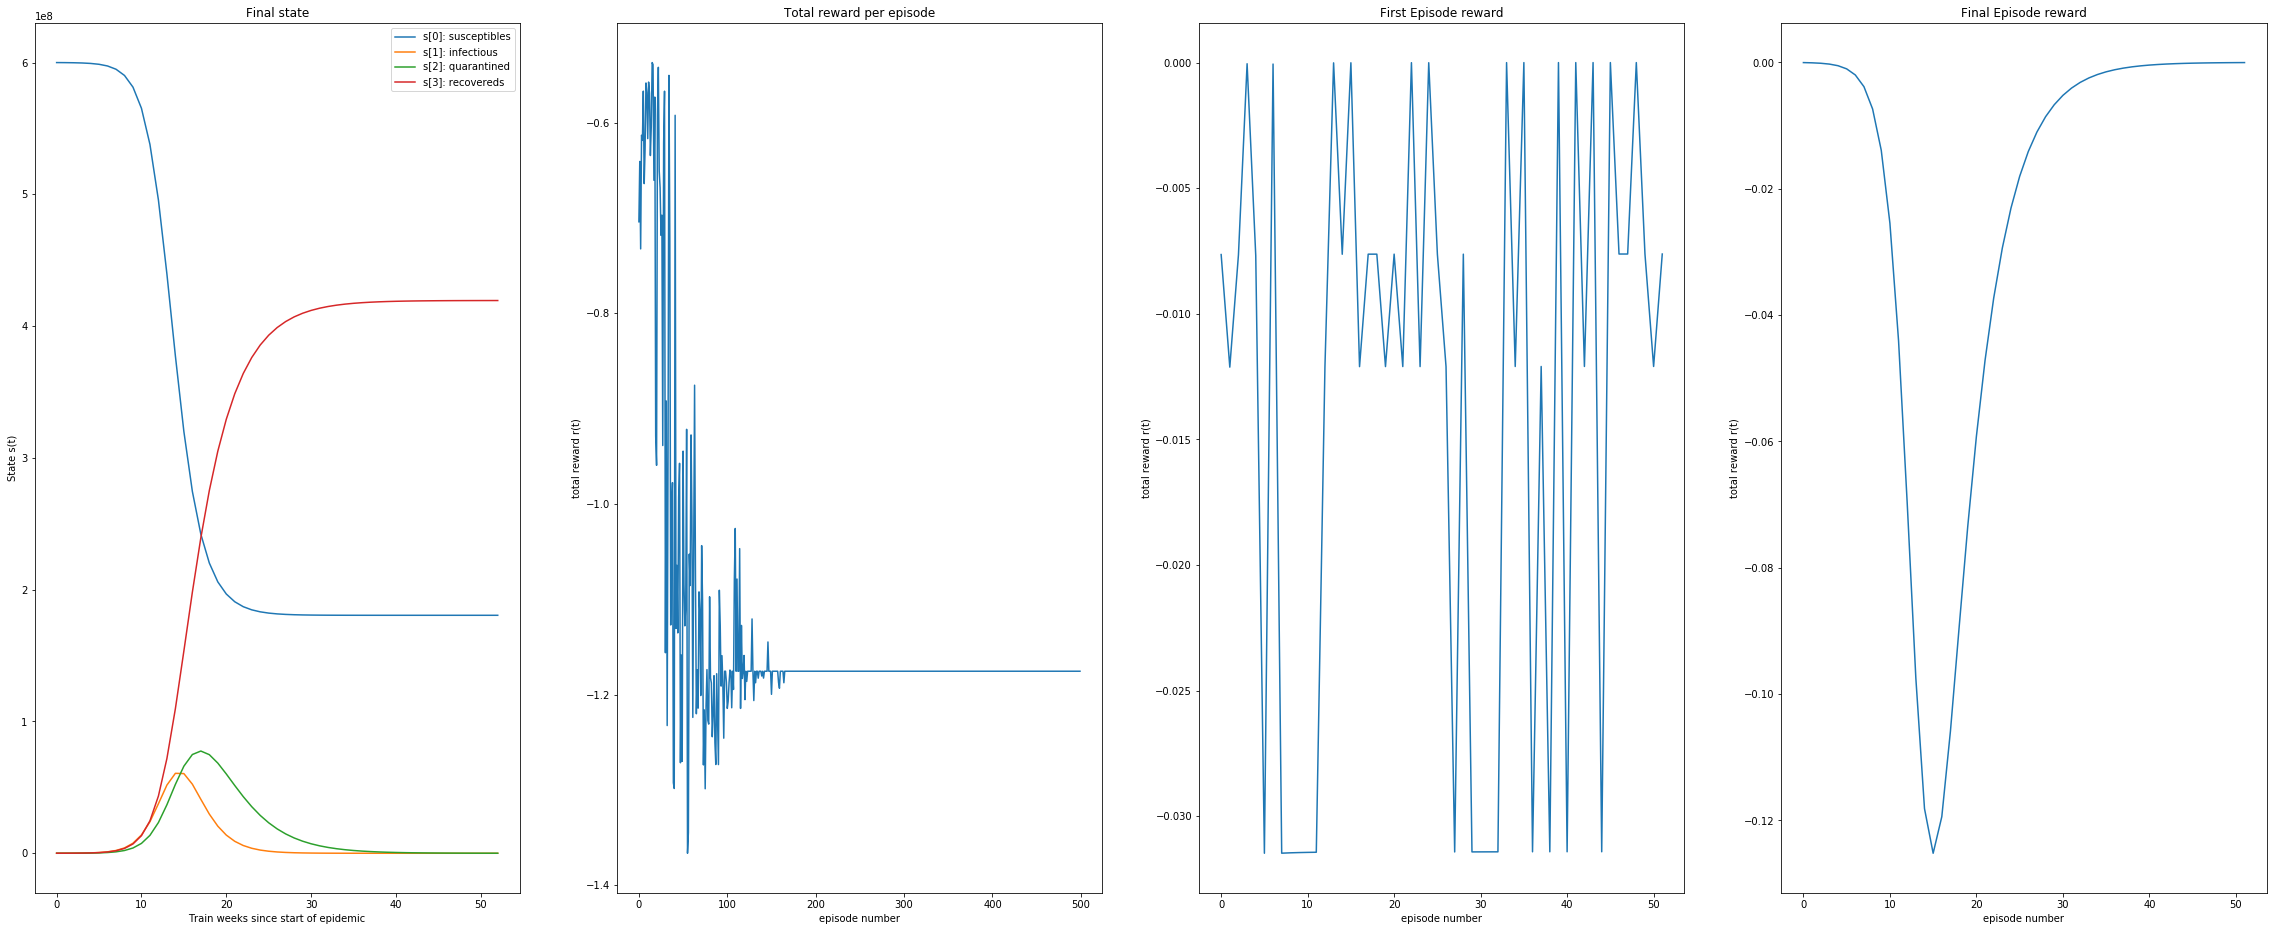

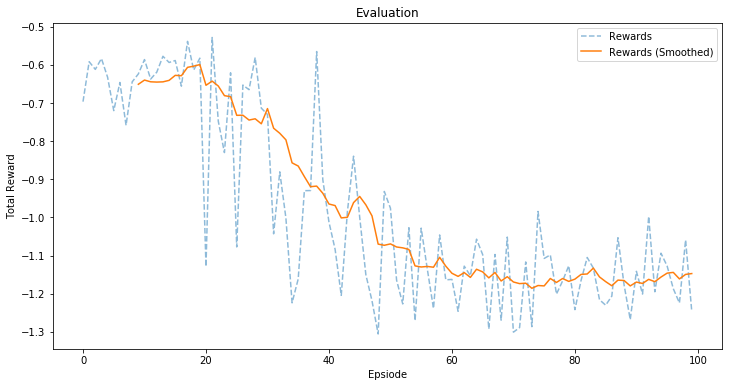

Problem id: 3

Decrease Factor: 0.0016


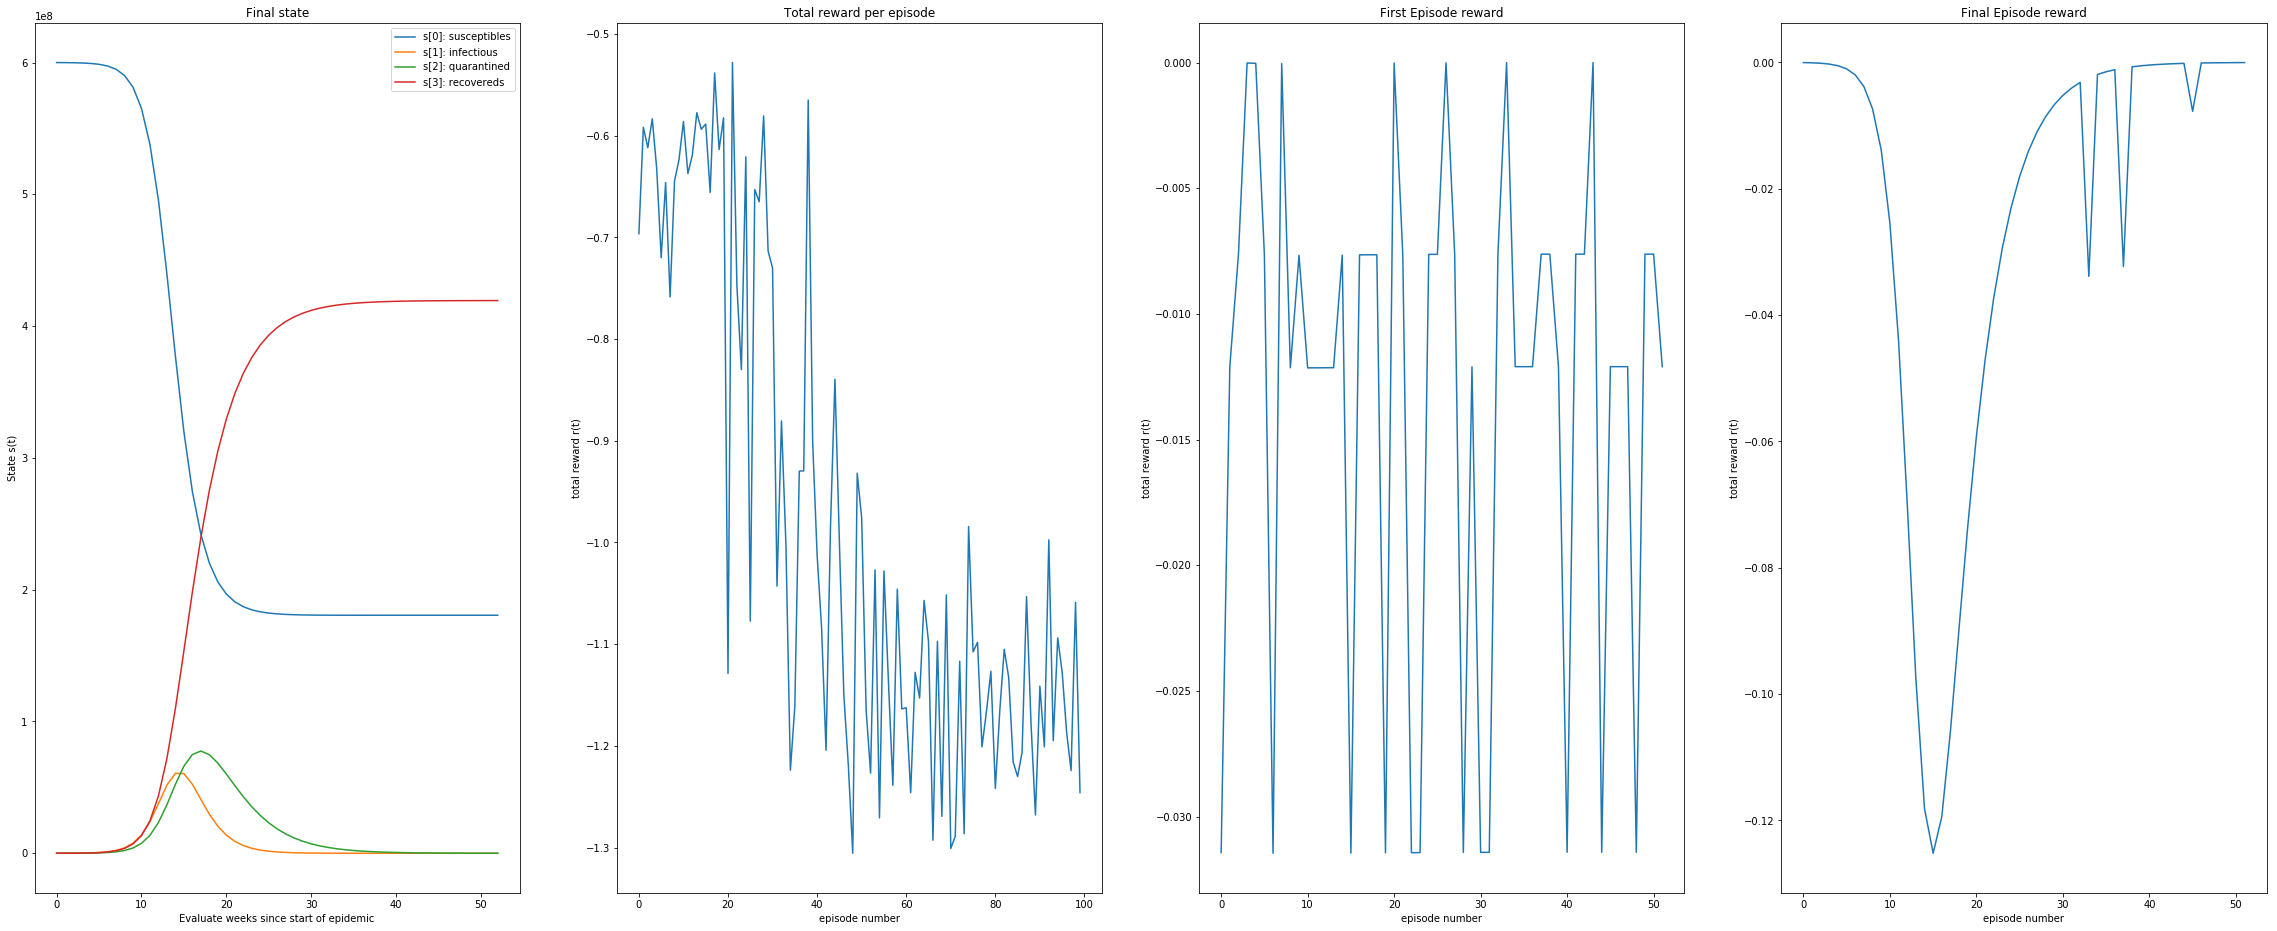

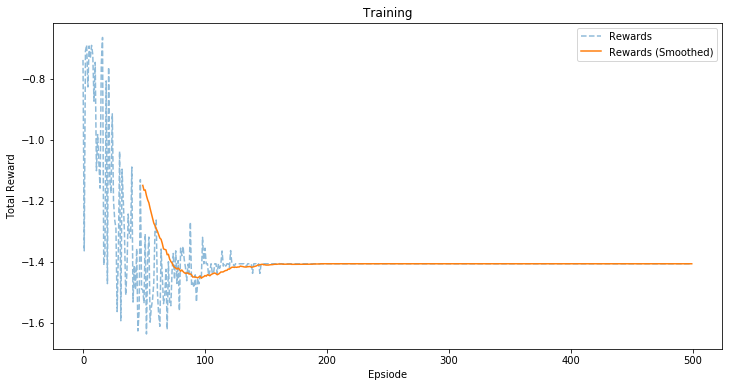

Train
Evaluate


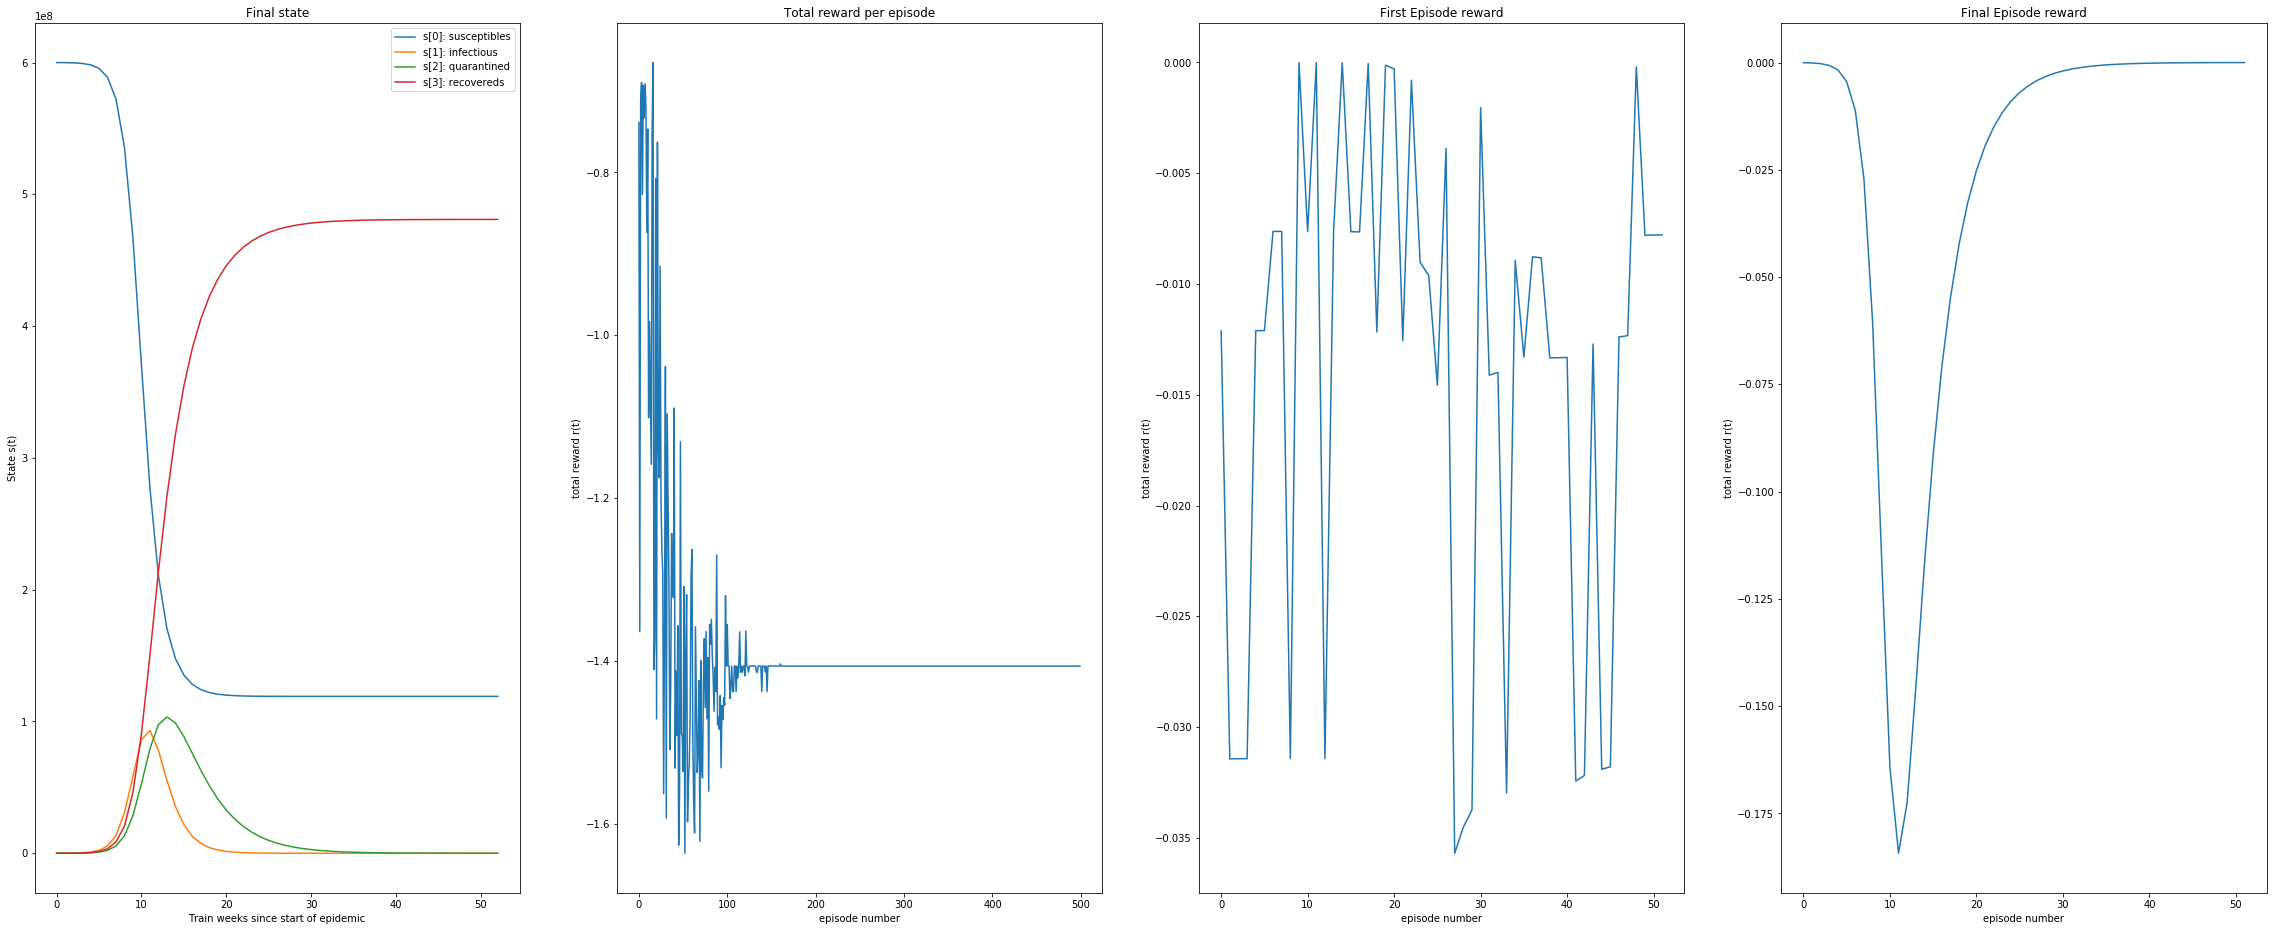

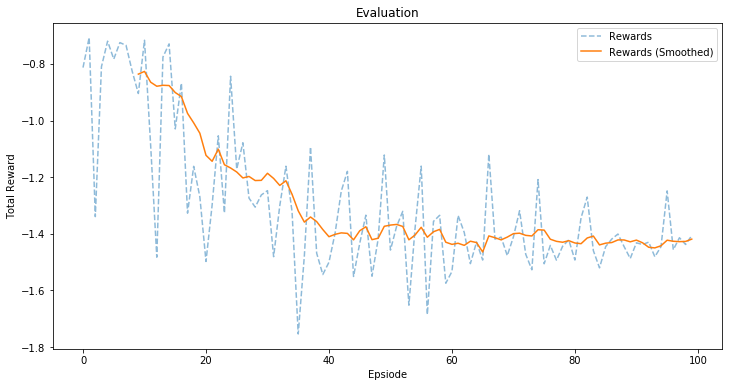

Problem id: 4

Decrease Factor: 0.0016


In [ ]:
for i in range(0,10):
    print("Problem id: " + str(i))
    print()
    env = virl.Epidemic(stochastic=False, noisy=False,problem_id=i)
    agent = LinearAprxAgent(env)
    states,all_rewards, all_total_rewards = agent.train()

    print("Train")

    plot(states,agent, all_total_rewards, all_rewards,"Train ")

    print("Evaluate")

    states,all_rewards, all_total_rewards = agent.evaluate()

    plot(states,agent, all_total_rewards, all_rewards,"Evaluate ")



In [ ]:
stochastic_noisy = {0:virl.Epidemic(stochastic=False, noisy=False),1:virl.Epidemic(stochastic=True, noisy=False),2:virl.Epidemic(stochastic=False, noisy=True),3:virl.Epidemic(stochastic=True, noisy=True)}
stochastic_noisy_print = {0:"stochastic=False, noisy=False",1:"stochastic=True, noisy=False",2:"stochastic=False, noisy=True",3:"stochastic=True, noisy=True"}

for i in range(0,4):
    
    env = stochastic_noisy[i]
    print(stochastic_noisy_print[i])
    agent = LinearAprxAgent(env)
    
    print("Train")
    states,all_rewards, all_total_rewards = agent.train()
    plot(states,agent, all_total_rewards, all_rewards,"Train ")

    print("Evaluate")
    states,all_rewards, all_total_rewards = agent.evaluate()
    plot(states,agent, all_total_rewards, all_rewards,"Evaluate ")



In [ ]:
total_reward_sd = np.std(all_total_rewards)
total_reward_mean = np.mean(all_total_rewards)
reward_sd = np.std(all_rewards)
reward_mean = np.mean(all_rewards)

print("Total reward standard deviation = " + str(total_reward_sd))
print("Total reward mean = " + str(total_reward_mean))
print("Reward standard deviation = " + str(reward_sd))
print("Rotal reward mean = " + str(reward_mean))